# **BA865 Project: Fashion Prediction with Neural Network**
## *Team Member: Boyuan (Daniel) Zhang, Tao Li, Mehul Agarwal*

## **1. Import Library & Dataset**

### 1.1 Import Library
Import operating system, file processing, data processing and deep learning related libraries.


In [17]:
# Imports and variables go here
import os
import io
import zipfile
import numpy as np
import pandas as pd
import random
import shutil
import time
import tempfile
import tensorflow as tf
import matplotlib.pyplot as plt
from threading import Lock
from tensorflow import keras
from google.api_core.exceptions import TooManyRequests
from google.cloud import storage
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras.utils import get_file
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### 1.2 Import the Dataset from Public Accessible Source
Decompress Image Data: Extract image data from a zip file in Google Drive and save it to the specified output folder.
Note: The output has been stored in the bucket, no need to rerun this part in the following work.

In [ ]:
# Set GCS paths for the input zip file and the output folder
zip_file = 'gs://mehul-nn-bucket/img.zip'
output_folder = 'img_test'

# Download the zip file from GCS to a temporary file
client = storage.Client()
bucket = client.bucket('mehul-nn-bucket')
blob = bucket.blob('img.zip')
temp_zip_file = tempfile.NamedTemporaryFile(delete=False)
blob.download_to_file(temp_zip_file)
temp_zip_file.close()

# Unzip files
# Open the zip file in read mode
with zipfile.ZipFile(temp_zip_file.name, 'r') as zip_ref:
    # Get the total number of files in the zip archive
    total_files = len(zip_ref.infolist())

    # Iterate over each file in the zip archive with a progress bar
    for zip_info in tqdm(zip_ref.infolist(), total=total_files, desc="Extracting"):
        # Set the destination path in the GCS bucket
        dest_path = os.path.join(output_folder, zip_info.filename)

        # If it's a directory, create it in the bucket
        if dest_path.endswith('/'):
            bucket.blob(dest_path).upload_from_string('')
        else:
            # Extract the file from the zip archive to a temporary file
            with tempfile.NamedTemporaryFile() as temp_extracted_file:
                with zip_ref.open(zip_info.filename) as zf, open(temp_extracted_file.name, 'wb') as tf:
                    tf.write(zf.read())
                # Upload the extracted file to the GCS bucket
                blob = bucket.blob(dest_path)
                blob.upload_from_filename(temp_extracted_file.name)

# Delete the temporary zip file
os.remove(temp_zip_file.name)

## **2. Pre-processing Implementation**

### 2.1 Re-classify Image Folders
Based on the category in the folder name, reclassify and move the folder to its corresponding category folder.

Because the original categories had over 3000+ classes, while there are only 40000+ images in our dataset. This meant that each category had very few images assigned to it, which could have made it difficult to train a model that could generalize well. By reducing the number of categories, each category had a sufficient number of images for training, which should help to build a better model.

In [ ]:
bucket_name = 'mehul-nn-bucket'
file_path = 'img_test/img'
processed_file_path = 'processed_img'
max_size = (180, 180)  # Adjust this value to the desired maximum width and height

client = storage.Client()
bucket = client.get_bucket(bucket_name)

def process_images(bucket, file_path, processed_file_path, max_size, max_images_per_category):
    blobs = list(bucket.list_blobs(prefix=file_path))
    total_blobs = len(blobs)

    # Filter out directories from the list of blobs
    filtered_blobs = [blob for blob in blobs if not blob.name.endswith('/')]

    # Group blobs by folder
    grouped_blobs = {}
    for blob in filtered_blobs:
        folder_path, file_name = os.path.split(blob.name)
        folder_path = folder_path.split("/")[-1]  # Update this line to extract the last part of the folder path
        if folder_path not in grouped_blobs:
            grouped_blobs[folder_path] = [blob]
        else:
            grouped_blobs[folder_path].append(blob)

    # Initialize category counters
    category_counters = {}

    # Process each folder
    for folder_path, blobs in grouped_blobs.items():
        category = folder_path.split("_")[-1]
        category_path = os.path.join(processed_file_path, category)

        # Ensure the category folder exists
        category_folder = bucket.blob(category_path + '/')
        if not category_folder.exists():
            category_folder.upload_from_string('')

        # Initialize the category counter if not already done
        if category not in category_counters:
            category_counters[category] = 0

        # Process images in the folder until the category limit is reached
        for blob in blobs:
            if category_counters[category] >= max_images_per_category:
                break

            file_name = os.path.basename(blob.name)
            # Include the folder name in the destination file name to ensure uniqueness
            unique_file_name = f"{folder_path}_{file_name}"
            file_dst = os.path.join(category_path, unique_file_name)

            # Check if the blob's name ends with a common image file extension
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff', '.webp')):
                # Download the image and resize it
                image_data = blob.download_as_bytes()
                with Image.open(io.BytesIO(image_data)) as img:
                    img.thumbnail(max_size)
                    with io.BytesIO() as output:
                        img.save(output, format=img.format)
                        output.seek(0)
                        dst_blob = bucket.blob(file_dst)
                        dst_blob.upload_from_file(output, content_type=blob.content_type)
            else:
                # Copy non-image files without processing
                bucket.copy_blob(blob, bucket, file_dst)

            # Increment the category counter
            category_counters[category] += 1

max_images_per_category = 500
process_images(bucket, file_path, processed_file_path, max_size, max_images_per_category)

In [3]:
def count_images(bucket, processed_file_path):
    blobs = list(bucket.list_blobs(prefix=processed_file_path))
    
    # Filter out directories from the list of blobs
    image_blobs = [blob for blob in blobs if not blob.name.endswith('/')]
    
    return len(image_blobs)

image_count = count_images(bucket, processed_file_path)
print(f"Total number of images in the processed_img folder: {image_count}")


Total number of images in the processed_img folder: 14641


## **3. Descriptive Statistics of the Dataset**

### 3.1 Descriptive Statistics

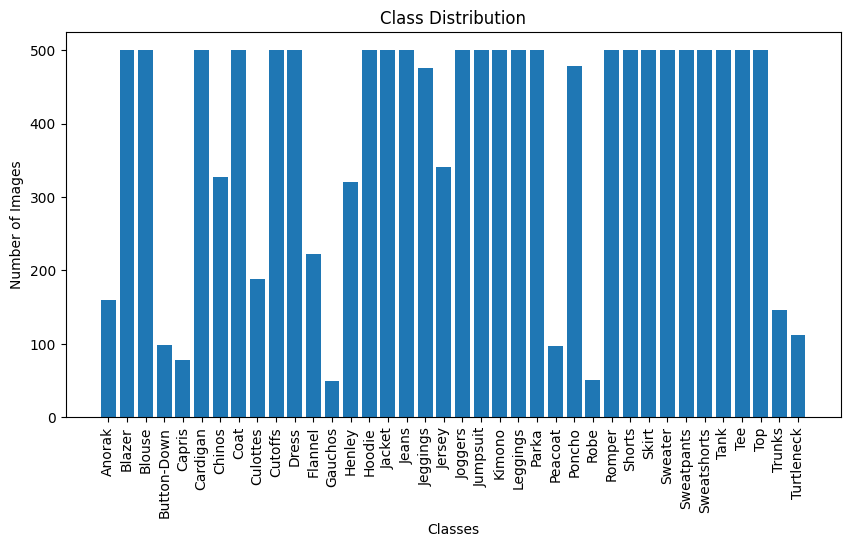

In [5]:
# Define a function to count the number of images in each subdirectory
def count_images_per_class(bucket, data_path):
    # List all blobs (files) in the given data_path
    blobs = list(bucket.list_blobs(prefix=data_path))

    # Get the unique subdirectories (class names)
    subdirs = set(os.path.dirname(blob.name) for blob in blobs if not blob.name.endswith('/'))

    class_counts = {}

    # Count images in each subdirectory
    for subdir in subdirs:
        class_name = os.path.basename(subdir)
        # List all blobs (files) in the current subdirectory
        class_blobs = list(bucket.list_blobs(prefix=subdir))
        # Filter out any subdirectories
        image_blobs = [blob for blob in class_blobs if not blob.name.endswith('/')]
        # Store the number of images for the current class
        class_counts[class_name] = len(image_blobs)

    # Return a dictionary containing the number of images per class
    return class_counts

# Call the count_images_per_class function to get the number of images for the data sets
class_counts = count_images_per_class(bucket, processed_file_path)

# Calculate the total number of images for data set
total_processed_images = sum(class_counts.values())

# Calculate the proportion of images in each class for the data sets
class_proportions = {k: v / total_processed_images for k, v in class_counts.items()}

# Define a function to plot the class distribution
def plot_class_distribution(class_counts, title):
    # Sort the class_counts dictionary by key (class name)
    sorted_class_counts = sorted(class_counts.items())

    # Get the sorted class names and the number of images per class
    classes = [item[0] for item in sorted_class_counts]
    counts = [item[1] for item in sorted_class_counts]

    # Create a bar chart to display the class distribution
    plt.figure(figsize=(10, 5))
    plt.bar(classes, counts)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

# Call the plot_class_distribution function to display the class distribution for the data sets
plot_class_distribution(class_counts, 'Class Distribution')


### 3.2 Remove Categories with Low Quantity to Balance the Class
According to the above figure, categories with less than 400 images in the train dataset will be removed to ensure balance between classes and improve model accuracy.

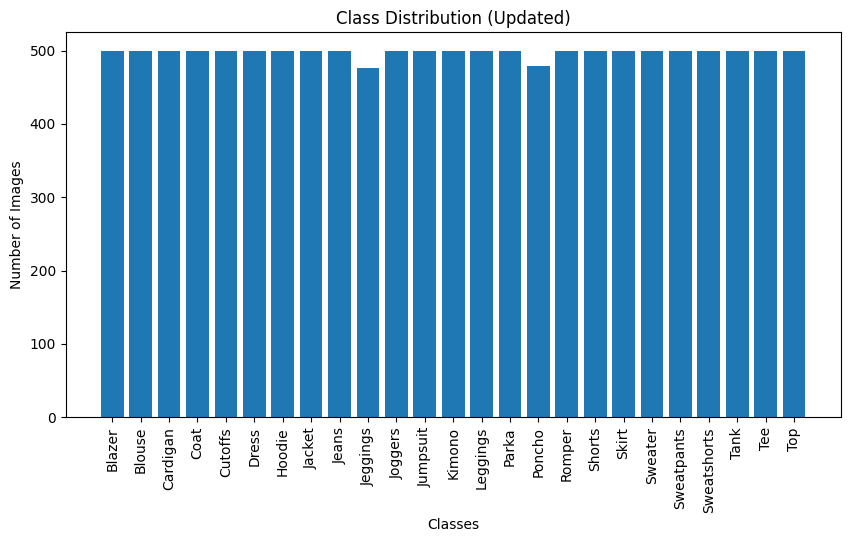

In [6]:
# Define a function to delete the filtered categories from a given folder
def delete_filtered_categories(bucket, folder_path, filtered_categories):
    for category in filtered_categories:
        category_path = os.path.join(folder_path, category)
        # List all blobs (files) in the current category
        category_blobs = list(bucket.list_blobs(prefix=category_path))
        
        # Delete each blob in the category
        for blob in category_blobs:
            blob.delete()

# Find categories with less than 40 images in the training set
filtered_categories = [category for category, count in class_counts.items() if count < 400]

# Remove the filtered categories from the class folders
delete_filtered_categories(bucket, processed_file_path, filtered_categories)

# Recount the images in the class folders
class_counts = count_images_per_class(bucket, processed_file_path)

# Display the updated class distributions
plot_class_distribution(class_counts, 'Class Distribution (Updated)')

### 3.3 Assessment of Class Balance
After removing categories with less than 400 samples in the dataset, the class distribution in the dataset seems to be balanced. This is a positive sign as a balanced class distribution ensures that the model learns from sufficient examples of each class, thus reducing the risk of overfitting to one particular class.

## **4. Split the Image Data into Training Set and Validation Set**
Traverse the processed image data folder and randomly allocate images to the training set and validation set.

In [7]:
# Function to copy images to train and val folders
def copy_images(bucket, root, directory, train_path, val_path, test_path, train_ratio, val_ratio):
    # Get the path of the current subfolder
    folder_path = os.path.join(root, directory)

    # List all blobs with the current subfolder prefix
    blobs = list(bucket.list_blobs(prefix=folder_path))

    # Filter out directories from the list of blobs
    image_blobs = [blob for blob in blobs if not blob.name.endswith('/')]

    # Shuffle the image blobs to create randomness
    random.shuffle(image_blobs)

    # Calculate the number of images for training and validation
    train_count = int(len(image_blobs) * train_ratio)
    val_count = int(len(image_blobs) * val_ratio)
    test_count = len(image_blobs) - train_count - val_count

    # Copy images to the corresponding train or val folders
    for i, image_blob in enumerate(image_blobs):
        src_path = image_blob.name
        if i < train_count:
            dest_folder = os.path.join(train_path, directory)
        elif i < train_count + val_count:
            dest_folder = os.path.join(val_path, directory)
        else:
            dest_folder = os.path.join(test_path, directory)

        dest_path = os.path.join(dest_folder, os.path.basename(image_blob.name))

        # Copy the image instead of moving it
        bucket.copy_blob(image_blob, bucket, dest_path)

# Function to process subfolders in the given data_path
def process_subfolders(bucket, data_path, train_path, val_path, test_path, train_ratio, val_ratio):
    blobs = list(bucket.list_blobs(prefix=data_path))

    # Get the unique subdirectories
    subdirs = set(os.path.dirname(blob.name) for blob in blobs if not blob.name.endswith('/'))

    # Process each subdirectory
    for subdir in subdirs:
        directory = os.path.basename(subdir)
        copy_images(bucket, data_path, directory, train_path, val_path, test_path, train_ratio, val_ratio)

In [8]:
# Set the folder path for the processed images and the temporary folder
# for train/val split
data_path = "processed_img"
temp_path = "temp_img"

# Set the split ratio (80% for training images, 10% for test and 10% for validation images)
train_ratio = 0.8
val_ratio = 0.1

# Create training and validation folders in the temporary path
train_path = os.path.join(temp_path, "train")
val_path = os.path.join(temp_path, "val")
test_path = os.path.join(temp_path, "test")

# Process subfolders to create train, test and val splits
process_subfolders(bucket, data_path, train_path, val_path, test_path, train_ratio, val_ratio)

# Print the message to indicate successful processing
print(f"The images in the subfolders have been successfully randomly divided\n \
       into training and validation sets!")


The images in the subfolders have been successfully randomly divided
        into training and validation sets!


## **5. Model Preparation**

### 5.1 Define Parameters

In [9]:
# Set related parameters
image_size = (180, 180)
batch_size = 32
num_classes = 25  # Modify according to the number of categories in the dataset.

### 5.2 Create Training and Validation Data Generators
Create training and validation data generators using ImageDataGenerator, while applying the preprocessing function required by VGG16.

In [ ]:
# Define your GCS bucket, train, and validation paths
train_gcs_path = 'gs://' + bucket_name + '/temp_img/train/*/*'
val_gcs_path = 'gs://' + bucket_name + '/temp_img/val/*/*'

def get_class_names(bucket, data_path):
    blobs = list(bucket.list_blobs(prefix=data_path))

    # Get the unique subdirectories
    subdirs = set(os.path.dirname(blob.name) for blob in blobs if not blob.name.endswith('/'))

    # Extract the class names from the subdirectories
    class_names = [os.path.basename(subdir) for subdir in subdirs]

    return class_names

class_names = get_class_names(bucket, data_path)

# Function to load and preprocess images
def load_image(image_file, label):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = preprocess_input(image)
    return image, label

def create_dataset(gcs_path, batch_size):
    file_list = tf.data.Dataset.list_files(gcs_path)
    
    # Extract labels from file paths
    labels = file_list.map(lambda x: tf.strings.split(x, os.sep)[-2], num_parallel_calls=tf.data.AUTOTUNE)
    
    # Create a StringLookup layer to convert class names to one-hot encoded labels
    label_lookup = StringLookup(vocabulary=list(class_names), num_oov_indices=1)
    labels = labels.map(lambda x: label_lookup(x), num_parallel_calls=tf.data.AUTOTUNE)
    labels = labels.map(lambda x: tf.one_hot(x, num_classes), num_parallel_calls=tf.data.AUTOTUNE)
    
    dataset = tf.data.Dataset.zip((file_list, labels))
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.repeat()  # Add this line to repeat the dataset indefinitely
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

train_dataset = create_dataset(train_gcs_path, batch_size)
val_dataset = create_dataset(val_gcs_path, batch_size)

## **6. CNN Base Model**

### 6.1 Build Simple Model

Defined a simple CNN model, then trained the training data using the fit method. Finally, used the evaluate method to calculate the accuracy of the model on the test dataset.

Epoch 1/10
100/100 [==============================] - 52s 515ms/step - loss: 18.7483 - accuracy: 0.0338 - val_loss: 3.0864 - val_accuracy: 0.0439
Epoch 2/10
100/100 [==============================] - 48s 482ms/step - loss: 3.0763 - accuracy: 0.0400 - val_loss: 3.0730 - val_accuracy: 0.0401
Epoch 3/10
100/100 [==============================] - 46s 464ms/step - loss: 3.0595 - accuracy: 0.0381 - val_loss: 3.0598 - val_accuracy: 0.0351
Epoch 4/10
100/100 [==============================] - 43s 431ms/step - loss: 3.0569 - accuracy: 0.0387 - val_loss: 3.0621 - val_accuracy: 0.0388
Epoch 5/10
100/100 [==============================] - 40s 400ms/step - loss: 3.0690 - accuracy: 0.0359 - val_loss: 3.0681 - val_accuracy: 0.0357
Epoch 6/10
100/100 [==============================] - 36s 356ms/step - loss: 3.0550 - accuracy: 0.0356 - val_loss: 3.0564 - val_accuracy: 0.0432
Epoch 7/10
100/100 [==============================] - 36s 366ms/step - loss: 3.0651 - accuracy: 0.0337 - val_loss: 3.0602 - val_a

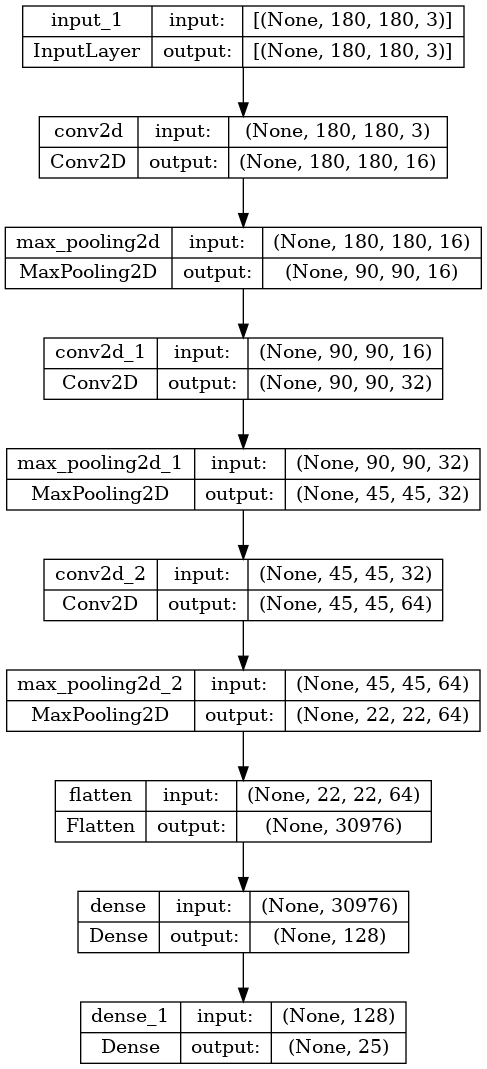

In [15]:
# Create a simple CNN model
def create_model():
    model = Sequential([
        layers.InputLayer(input_shape=(180, 180, 3)),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

    return model

# Create and train the model
model = create_model()
history = model.fit(train_dataset, epochs=10, steps_per_epoch=100, validation_data=val_dataset, validation_steps=50)

# Load the test dataset
test_gcs_path = 'gs://' + bucket_name + '/temp_img/test/*/*'
test_dataset = create_dataset(test_gcs_path, batch_size)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset, steps=50)
print(f"Test accuracy: {test_accuracy}")

# Draw a picture of the model... 
keras.utils.plot_model(model,show_shapes=True)

### 6.2 Build Improved CNN Model

We have made the following improvements to the model:
  1. Increased the number of neurons in convolutional and fully connected layers so that the model can learn more complex features.
  2. Added batch normalization layer to speed up training process and improve model performance.
  3. Added a Dropout layer after the fully connected layer to reduce overfitting.
  4. Used data augmentation by applying random transformations to training images to increase dataset diversity.
  5. Increased the number of epochs for better performance.

In [19]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom

num_classes = 25  # Update the number of categories.

# Function to create a dataset with data augmentation
def create_dataset_with_augmentation(gcs_path, batch_size):
    dataset = create_dataset(gcs_path, batch_size)
    dataset = dataset.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

# Create a data augmentation layer
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

# Create a function to build the model with transfer learning
def create_model_with_transfer_learning():
    # Load a pre-trained EfficientNetB0 model without the top layer
    base_model = EfficientNetB0(input_shape=(180, 180, 3), include_top=False, weights='imagenet')

    # Freeze the base model
    base_model.trainable = False

    # Add custom layers
    model = Sequential([
        layers.InputLayer(input_shape=(180, 180, 3)),
        data_augmentation,
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

    return model

# Create and train the model with transfer learning
model = create_model_with_transfer_learning()
train_dataset_augmented = create_dataset_with_augmentation(train_gcs_path, batch_size)
history = model.fit(train_dataset_augmented, epochs=10, steps_per_epoch=100, validation_data=val_dataset, validation_steps=50)

# Load the test dataset
test_dataset = create_dataset(test_gcs_path, batch_size)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset, steps=50)
print(f"Test accuracy: {test_accuracy}")


16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/10
100/100 [==============================] - 56s 503ms/step - loss: 3.1200 - accuracy: 0.0391 - val_loss: 3.1120 - val_accuracy: 0.0426
Epoch 2/10
100/100 [==============================] - 49s 490ms/step - loss: 3.0886 - accuracy: 0.0372 - val_loss: 3.0902 - val_accuracy: 0.0439
Epoch 3/10
100/100 [==============================] - 49s 487ms/step - loss: 3.0886 - accuracy: 0.0406 - val_loss: 3.0927 - val_accuracy: 0.0407
Epoch 4/10
100/100 [==============================] - 49s 487ms/step - loss: 3.0873 - accuracy: 0.0434 - val_loss: 3.0885 - val_accuracy: 0.0414
Epoch 5/10
100/100 [==============================] - 49s 489ms/step - loss: 3.0812 - accuracy: 0.0344 - val_loss: 3.0759 - val_accuracy: 0.0395
Epoch 6/10
100/100 [==============================] - 49s 489ms/step - loss: 3.0664 - accuracy: 0.0419 - val_loss: 3.0819 - val_accuracy: 0.0395
Epoch 7/10
100/100 [==============================] - 49s 487ms/s

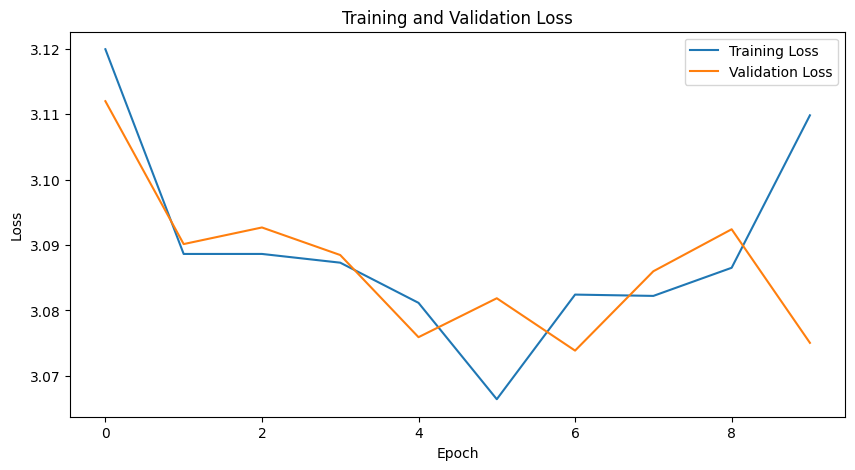

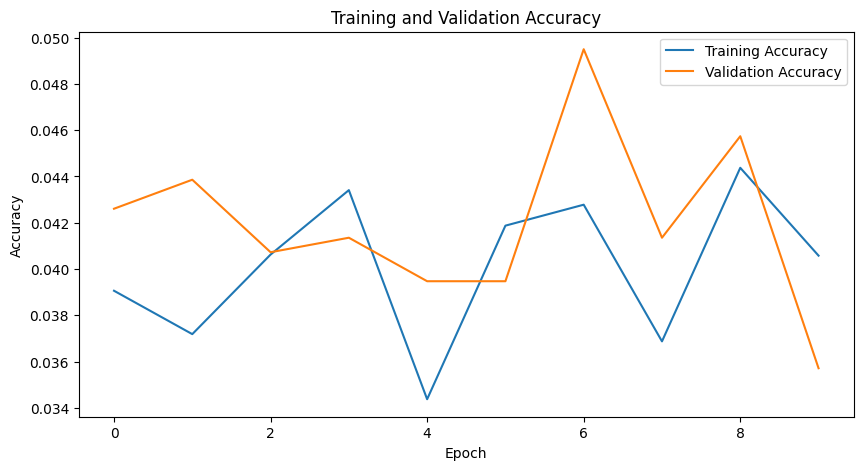

In [20]:
def plot_training_history(history):
    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

# Call the function to plot the training history
plot_training_history(history)


## **7. Evaluate the Model on the Test Set**

### 7.1 Evaluate the Model on the Test Set

Use test dataset to evaluate model performance.

In [27]:
# Update the GCS path for the test dataset
test_gcs_path = 'gs://' + bucket_name + '/temp_img/test/*/*'

# Create a test dataset
test_dataset = create_dataset(test_gcs_path, batch_size)

# Evaluate the improved model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset, steps=50)
print(f"Test accuracy: {test_accuracy}")


50/50 [==============================] - 85s 2s/step - loss: 21.5385 - accuracy: 0.0469
Test accuracy: 0.046875


### 7.2 Visualize the Model Performance

50/50 [==============================] - 85s 2s/step


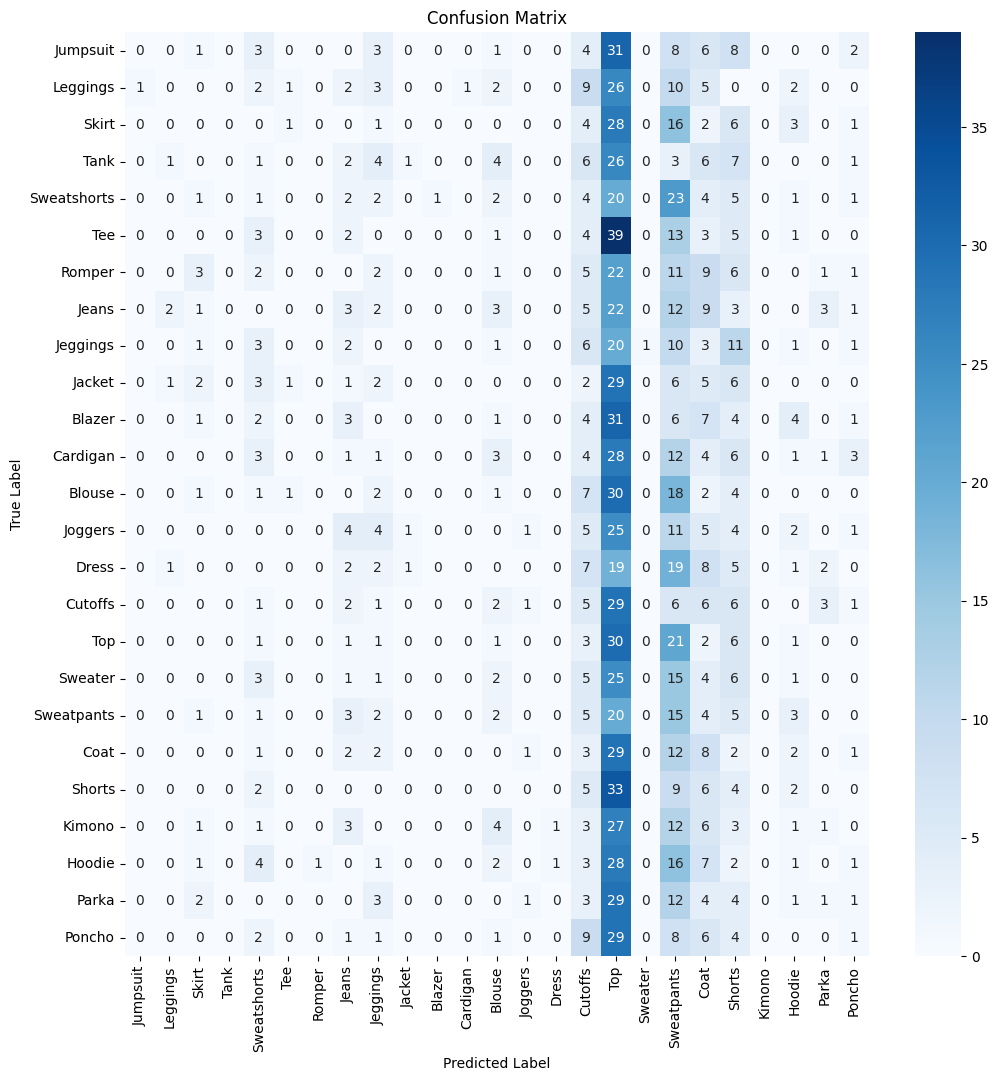

              precision    recall  f1-score   support

    Jumpsuit       0.00      0.00      0.00        67
    Leggings       0.00      0.00      0.00        64
       Skirt       0.00      0.00      0.00        62
        Tank       0.00      0.00      0.00        62
 Sweatshorts       0.03      0.01      0.02        67
         Tee       0.00      0.00      0.00        71
      Romper       0.00      0.00      0.00        63
       Jeans       0.08      0.05      0.06        66
    Jeggings       0.00      0.00      0.00        60
      Jacket       0.00      0.00      0.00        58
      Blazer       0.00      0.00      0.00        64
    Cardigan       0.00      0.00      0.00        67
      Blouse       0.03      0.01      0.02        67
     Joggers       0.25      0.02      0.03        63
       Dress       0.00      0.00      0.00        67
     Cutoffs       0.04      0.08      0.05        63
         Top       0.04      0.45      0.08        67
     Sweater       0.00    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Get true labels and predictions
y_true = np.concatenate([y for x, y in test_dataset.take(50)], axis=0)
y_pred = model.predict(test_dataset, steps=50)

# Convert true labels and predictions from one-hot encoding to class indices
y_true = np.argmax(y_true, axis=1)
y_pred = np.argmax(y_pred, axis=1)

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names)

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))


## **8. Suggestion to Improve Performance**